# Kernel Density Estimation in Python

*This notebook originally appeared as a*
[*blog post*](http://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)
*by Jake Vanderplas on*
[*Pythonic Perambulations*](http://jakevdp.github.io/).
*Content is BSD licensed*

<!-- PELICAN_BEGIN_SUMMARY -->
Last week Michael Lerner posted a [nice explanation](http://www.mglerner.com/blog/?p=28)
of the relationship between histograms and kernel density estimation (KDE).  I've made some
attempts in this direction before
(both in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/density.html)
and in our upcoming [textbook](http://www.amazon.com/Statistics-Mining-Machine-Learning-Astronomy/dp/0691151687/)),
but Michael's use of interactive javascript widgets makes the relationship extremely intuitive.
I had been planning to write a similar post on the theory behind KDE and why it's useful, but
Michael took care of that part.  Instead, I'm going to focus here on comparing the actual
*implementations* of KDE currently available in Python.  If you're unsure what kernel density
estimation is, read Michael's post and then come back here.

There are several options available for computing kernel density estimates in Python.
The question of the optimal KDE implementation for any situation, however,
is not entirely straightforward, and depends a lot on what your particular goals are.
Here are the four KDE implementations I'm aware of in the SciPy/Scikits stack:

- In [SciPy](http://scipy.org): [``gaussian_kde``](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).

- In [Statsmodels](http://statsmodels.sourceforge.net/): [``KDEUnivariate``](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/kernel_density.html) and [``KDEMultivariate``](http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.kde.KDEUnivariate.html) (See an example [here](http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)).

- In [Scikit-learn](http://scikit-learn.org): [``KernelDensity``](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) (See further examples [here](http://scikit-learn.org/stable/modules/density.html#kernel-density-estimation)).

Each has advantages and disadvantages, and each has its area of applicability.
I'll start with a table summarizing the strengths and weaknesses of each, before
discussing each feature in more detail and running some simple benchmarks to gauge
their computational cost:

<!-- PELICAN_END_SUMMARY -->

<style type="text/css">
table.mytable{
border-collapse:collapse;
border: 5px solid #DDDDDD;
}
td.green{background-color:#DDFFDD;}
td.red{background-color:#FFDDDD;}

.mytable td{font-size:80%}
</style>

<table class="mytable">
<tr>
 <td></td>
 <td>Bandwidth<br>Selection</td>
 <td>Available<br>Kernels</td>
 <td>Multi-<br>dimension</td>
 <td>Heterogeneous<br>data</td>
 <td>FFT-based<br>computation</td>
 <td>Tree-based<br>computation</td>
</tr>
<tr>
 <th>Scipy</th>
 <td class="green">Scott &<br>Silverman</td>
 <td class="red">One (Gauss)</td>
 <td class="green">Yes</td>
 <td class="red">No</td>
 <td class="red">No</td>
 <td class="red">No</td>
</tr>
<tr>
 <th>Statsmodels<br>KDEUnivariate</th>
 <td class="green">Scott &<br>Silverman</td>
 <td class="green">Seven</td>
 <td class="red">1D only</td>
 <td class="red">No</td>
 <td class="green">Yes</td>
 <td class="red">No</td>
</tr>
<tr>
 <th>Statsmodels<br>KDEMultivariate</th>
 <td class="green">normal reference<br>cross-validation</td>
 <td class="green">Seven</td>
 <td class="green">Yes</td>
 <td class="green">Yes</td>
 <td class="red">No</td>
 <td class="red">No</td>
</tr>
<tr>
 <th>Scikit-Learn</th>
 <td class="red">None built-in;<br>Cross val. available</td>
 <td class="green">6 kernels x<br>12 metrics</td>
 <td class="green">Yes</td>
 <td class="red">No</td>
 <td class="red">No</td>
 <td class="green">Ball Tree<br>or KD Tree</td>
</tr>
</table>

## Comparing the Implementations

The four implementations mentioned above have very different interfaces.  For the sake of the examples and benchmarks below, we'll start by defining a uniform interface to all four, assuming one-dimensional input data.  The following functions should make clear how the interfaces compare:

In [1]:
kw = {'a': 1, 'b': 2}
def s(a, b): 
    return a + b

s(1, 2), s(**kw)

(3, 3)

In [4]:
x = np.array([1, 2])
x.shape, x[:, np.newaxis].shape, x[np.newaxis, :].shape

((2,), (2, 1), (1, 2))

In [16]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print( "Package Versions:")
import sklearn; print( "  scikit-learn:", sklearn.__version__)
import scipy; print ("  scipy:", scipy.__version__)
import statsmodels; print( "  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 1.2.2
  scipy: 1.11.4
  statsmodels: 0.15.0.dev202+g23faea30e


In [11]:
x = np.array([1,2,3,4])
x[:,None].shape

(4, 1)

<font color ='red'>  **If you don't have installed `scikit-learn` use this link to install [link](https://scikit-learn.org/stable/install.html)**. Remember that if you are using the anaconda environment you need to use de `conda` instalation

Because several of these are newer functionalities (in particular, the ``KernelDensity`` estimator
was added in version 0.14 of Scikit-learn), I added an explicit print-out of the versions used
in running this notebook.

Now that we've defined these interfaces, let's look at the results of the four
KDE approaches. We'll start with the normal
matplotlib backend command, and then plot visualizations of the four results on
the same 1 dimensional bimodal data:

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

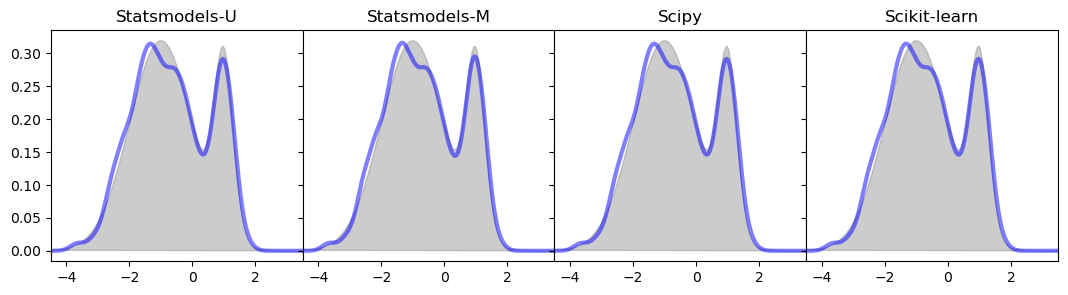

In [19]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

### Another way to see the KDE using seaborn package (ONLY data representation in the frequency domain)

In [21]:
import seaborn as sns

<Axes: ylabel='Density'>

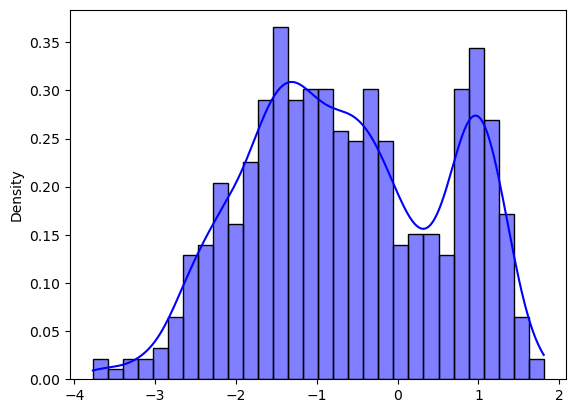

In [22]:
sns.histplot(data=x, stat='density', kde=True, kde_kws={'bw_method': .2}, color='b', bins=30)

<Axes: ylabel='Density'>

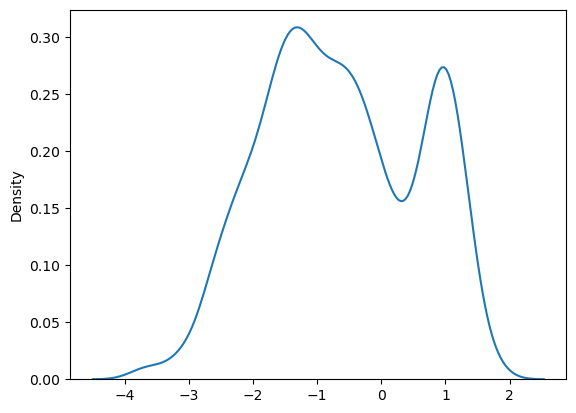

In [23]:
sns.kdeplot(data=x, bw_method=0.2)

The results are identical, as we'd expect: all four algorithms are effectively computing the same result by different means.

## Features of the Algorithms

Given that the results of the algorithms (for 1 dimensinoal data, at least) are essentially equivalent, **why would you use one over another?** The answer to that lies a bit deeper in the theory of how KDE is computed and applied. Above I showed a table that summarizes some of the **advantages and disadvantages of each algorithm**: here' I'll discuss a few of those features in a bit more detail:

### Bandwidth selection

The selection of bandwidth is an important piece of KDE.  For the same input data, different bandwidths can produce very different results:

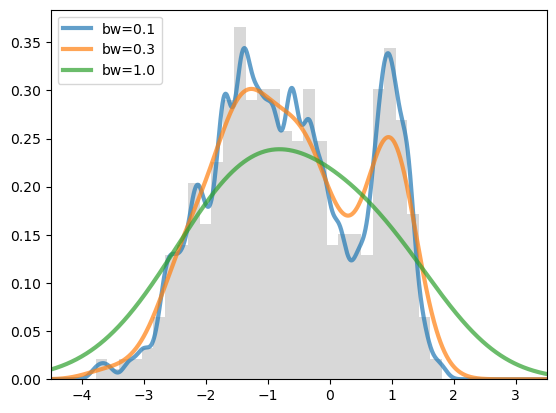

In [24]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')

**Using different bandwidths can lead to entirely different ideas of the underlying nature of the data!**
Given the importance of bandwidth, how might you determine the optimal bandwidth for any given problem?

There are two classes of approaches to this problem: in the statistics community, it is common to use
**reference rules**, where the optimal bandwidth is estimated from theoretical forms **based on assumptions about the data distribution.**  A common reference rule is *Silverman's rule*, which is derived for univariate
KDE and included within both the Scipy and Statsmodels implementations.  Other potential reference rules
are ones based on Information Criteria, such as the well-known AIC and BIC.

In the Machine Learning world, the use of reference rules is less common. Instead, an empirical approach
such as **[cross validation](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html)** is often used.  In cross validation, the model is fit to part of the data,
and then a quantitative metric is computed to determine how well this model fits the remaining data.  Such an
empirical approach to model parameter selection is very flexible, and can be used regardless of the
underlying data distribution.

Because the various reference rules generally depend on (often dubious) assumptions about the underlying distribution of
the data, bandwidth selection based in **cross-validation can produce more trustworthy results for real-world datasets.**  A leave-one-out cross-validation scheme is built-in to the Statsmodels ``KDEMultivariate`` class.
For large datasets, however, leave-one-out cross-validation can be extremely slow.  Scikit-learn does not
currently provide built-in cross validation within the ``KernelDensity`` estimator, but the standard cross
validation tools within the module can be applied quite easily, as shown in the example below.

#### Bandwidth Cross-Validation in Scikit-Learn
Using cross validation within Scikit-learn is straightforward with the ``GridSearchCV`` meta-estimator:

In [19]:
x.mean()

-0.6235954491149853

In [25]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 0.19310344827586207}


In [26]:
x_grid.shape

(1000,)

In [27]:
grid.best_estimator_

KernelDensity(bandwidth=0.19310344827586207)

According to the cross-validation score (i.e. the maximum likelihood),
the best bandwidth is around 0.19.  Let's plot the result:

Text(0.5, 1.0, 'KDE using scikit-learn')

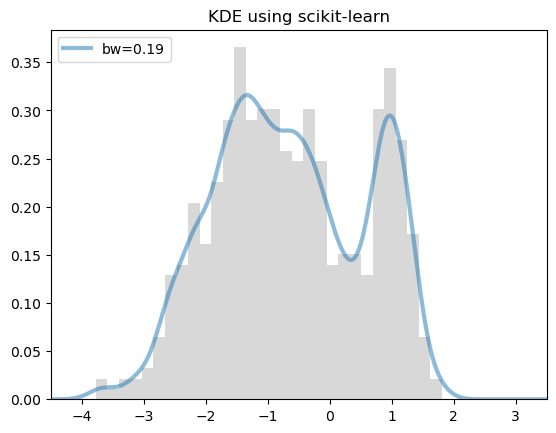

In [28]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-4.5, 3.5);
ax.set_title('KDE using scikit-learn')

#### Bandwidth Cross-Validation in Stats-models

In [38]:
kde = KDEMultivariate(x, 
                      bw='cv_ml',  #bandwidth * np.ones_like(x),
                      var_type='c')
pdf = lambda x: kde.pdf(x) 

# pdf = lambda x_grid: kde.pdf(x_grid)

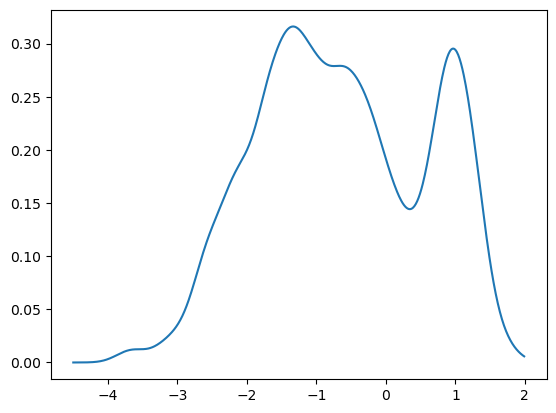

In [42]:
# How to obtain a function instead of an array of values from KDEMultivariate?
def kde_statsmodels_m_func(x, n_terminos, tec_red_var1=1,  tec_red_var2=0, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    pdf = lambda x_grid: kde.pdf(x_grid)
    
#     if tec_red_var1 == 1:
#         # Aplican la tecnica de reducción de varianza 1
#     elif tec_red_var2 == 1:
#         # Aplican la tecnica de reducción de varianza 1
#     else:
#         # aplica método de aceptación y rechazo

    return pdf

kde1 = kde_statsmodels_m_func(x, 10)
x1 = np.arange(-4.5, 2, 0.01)
plt.plot(x1, kde1(x1))

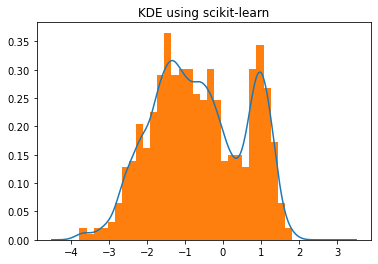

In [66]:
# How to obtain a function instead of an array of values from sklearn KDE?


We see that the cross-validation yields a bandwidth which is close to what we might choose by-eye,
and the resulting density estimate closely reflects the distribution of the underlying data.

### Kernels
Above we've been using the Gaussian kernel, but this is not the only available option.  KDE can be used with any
kernel function, and different kernels lead to density estimates with different characteristics.

The Scipy KDE implementation contains only the common Gaussian Kernel.  Statsmodels contains seven kernels,
while Scikit-learn contains six kernels, each of which can be used with one of about a dozen distance
metrics, resulting in a very flexible range of effective kernel shapes.

Here is a quick visualization of the six kernel forms available in Scikit-learn. For clarity, the ``plot_kernels()``
function used here is defined at the end of the notebook:

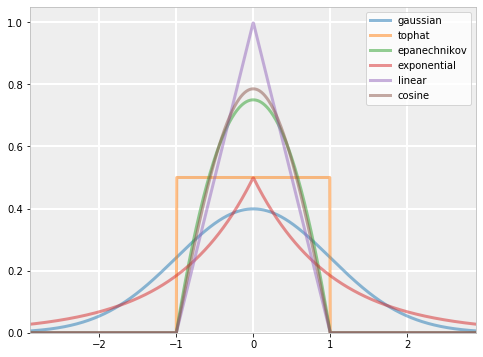

In [54]:
plot_kernels()

The various kernel shapes lead to estimators with very different characteristics.  For some
examples of these in action, see the
[Scikit-learn documentation](http://scikit-learn.org/stable/modules/density.html#kernel-density-estimation)
or the [AstroML examples](http://www.astroml.org/book_figures/chapter6/fig_great_wall_KDE.html#book-fig-chapter6-fig-great-wall-kde).

### Heterogeneous Data

One advantage that Statsmodels' ``KDEMultivariate`` has over the other algorithms is its
ability to handle heterogeneous data, i.e. a mix of continuous, ordered discrete, and
unordered discrete variables.  All of the other implementations require homogeneous
datasets.  Though the problem of heterogeneous data is interesting, I won't discuss
it more here.  For more details, see the
[KDEMultivariate documentation](http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html).

### FFT-based computation

For large datasets, a kernel density estimate can be computed efficiently via the convolution theorem using a fast Fourier transform.  This requires binning the data, so the approach quickly becomes inefficient in higher dimensions.  Of the four algorithms discussed here, only Statsmodels' ``KDEUnivariate`` implements an FFT-based KDE.  As we'll see below, the FFT provides some computational gains for large numbers of points, but in most situations is not as effective as tree-based KDE implementations.

### Tree-based computation
For *M* evaluations of *N* points, the KDE computation naively requires $\mathcal{O}[MN]$ computations (i.e. a distance computation between each input/output pair). This puts KDE in the same category as Nearest Neighbors, *N*-point correlation functions, and Gaussian Process Regression, all of which are examples of [Generalized N-body](http://www.cs.cmu.edu/~agray/nbody.html) problems which can be efficiently computed using specialized data structures such as a **KD Tree** (I discussed spatial trees in the context of nearest neighbors searches in a [previous blog post](http://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/)).

The main idea is this: if you can show that a query point $Q_0$ is geometrically far from a set of training points $\{T_i\}$, then you no longer need to compute *every* kernel weight between $Q_0$ and the points in $\{T_i\}$: it is sufficient to compute one kernel weight at the average distance, and use that as a proxy for the others.  With careful consideration of the bounds on the distances and the maximum error tolerance for the final result, it is possible to greatly reduce the number of required operations for a KDE computation.

For the 0.14 release of Scikit-learn, I wrote an efficient KDE implementation built on a KD Tree and a Ball Tree.  By setting the parameters ``rtol`` (relative tolerance) and ``atol`` (absolute tolerance), it is possible to compute very fast approximate kernel density estimates at any desired degree of accuracy.  The final result $p$ is algorithmically guaranteed to satisfy

$$
{\rm abs}\left(p - p_{true}\right) < {\tt atol} + {\tt rtol} \cdot p_{true}
$$

This scheme effectively sets up a tradeoff between computation time and accuracy.  As we'll see below, even marginal reduction in accuracy (say, allowing errors of 1 part in $10^8$) can lead to impressive gains in computational efficiency.

## Computational Efficiency

Next comes the fun part: comparing the computational efficiency of the various
algorithms.  Here we'll look at the computation time as a function of the number
of points in the distribution for a *1-dimensional* case.  As noted above, several
of the algorithms also implement multi-dimensional computations: the scaling with
the number of points should not change appreciably in the multi-dimensional case.

Here and throughout, we will compute the KDE for 5000 query points.  For clarity, the
``plot_scaling`` function used here is defined at the end of the notebook: if you
download and run this notebook, please scroll down and execute that cell first.

### Scaling with the Number of Points

First we'll look at the scaling with the number of points in the input distribution,
spread from 10 points to 10,000 points:

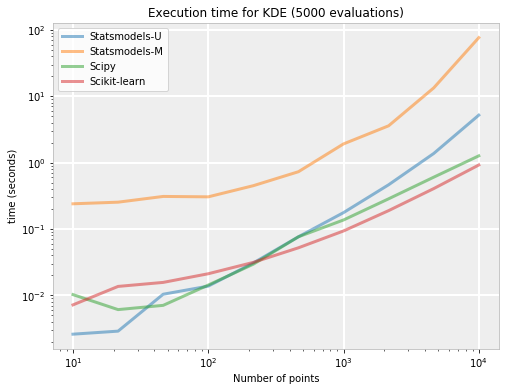

In [56]:
plot_scaling(N=np.logspace(1, 4, 10),
             kwds={'Statsmodels-U':{'fft':False}});

The ``SciPy`` algorithm (red line) exhibits the expected $\mathcal{O}[N]$ scaling for
a naive KDE implementation.  The tree-based implementation in scikit-learn is slightly
better for a large number of points (for small datasets, the overhead of building the
tree dominates).  Both statsmodels implementations are appreciably slower: in particular,
the ``KDEMultivariate`` implementation displays a relatively large computational overhead.

However, these benchmarks are not entirely fair to the Statsmodels Univariate algorithm
or to the Scikit-learn algorithm.  For ``KDEUnivariate``, we have not used the FFT version
of the calculation; for Scikit-learn, we've set ``rtol`` and ``atol`` to zero, effectively
asking the algorithm for a perfectly precise computation which allows very few tree nodes
to be trimmed from the calculation.

Let's change this, and use the FFT computation for statsmodels, and set ``rtol=1E-4`` for
scikit-learn.  The latter setting says that we want a faster computation, at the expense of
accepting a 0.01% error in the final result:

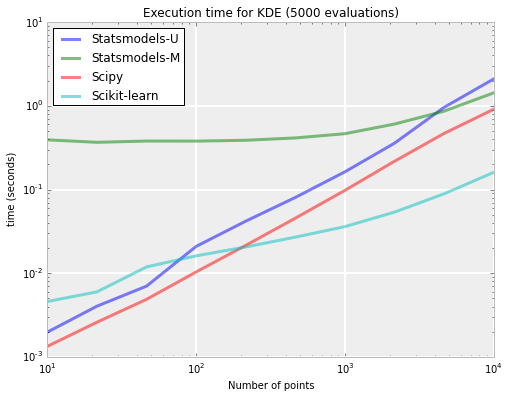

In [10]:
plot_scaling(N=np.logspace(1, 4, 10),
             rtol=1E-4,
             kwds={'Statsmodels-U':{'fft':True}});

The FFT computation significantly speeds the statsmodels univariate computation in the case
of large numbers of points.  The real winner here, though, is the Scikit-learn implementation:
by allowing errors of 1 part in 10,000, we've sped the computation for the largest datasets by
an additional factor of 5 or so, making it an order of magnitude faster than the next best algorithm!

### Dependence on ``rtol``

You might wonder what the effect of ``rtol`` is on the speed of the computation.
In most situations for the scikit-learn estimator, **increasing ``rtol`` will directly
lead to an increase in computational efficiency**, as distant tree nodes are able to be
trimmed earlier in the computation.

To illustrate this, we'll plot the computation time as a function of ``rtol``, from
$1$ part in $10^{16}$ (effectively the floating point precision on 64-bit machines)
all the way up to $1$ part in $10$ (i.e. 10% error on the results):

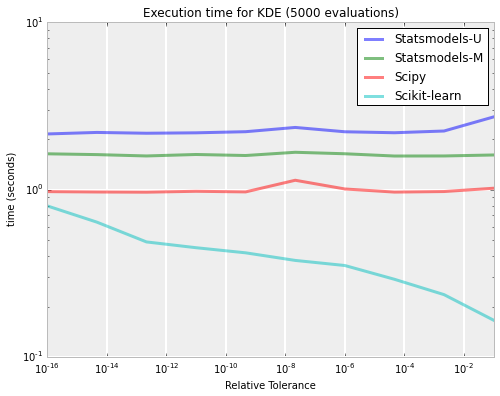

In [11]:
plot_scaling(N=1E4,
             rtol=np.logspace(-16, -1, 10),
             bandwidth=0.2);

This plot displays the direct tradeoff between precision and efficiency enabled by Scikit-learn's tree-based algorithms.
Any variation in the timing for the other algorithms is simply statistical noise: they cannot take advantage of ``rtol``.

### Dependence on Bandwidth
One somewhat counter-intuitive effect of the tree-based approximate KDE is that the bandwidth
becomes an important consideration in the time for computation.  This is because the bandwidth
effectively controls how "close" points are to each other.

When points are very far apart in relation to the kernel size, their contribution to the density
is very close to zero.  In this range, whole groups of such points can be removed
from the computation.  When points are very close together in relation to the kernel
size, the distance is effectively zero, and whole groups of such points in the tree
can be considered, as a group, to contribute the maximal kernel contribution.

The tree-based KDE computation in Scikit-learn takes advantage of these situations, leading to
a strong dependence of computation time on the bandwidth: for very small and very large bandwidths,
it is fast.  For bandwidths somewhere in the middle, it can be slower than other algorithms, 
primarily due to the computational overhead of building and traversing the tree:

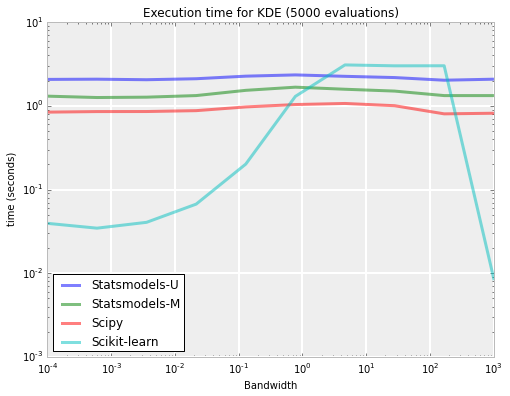

In [12]:
plot_scaling(N=1E4, rtol=1E-4,
             bandwidth=np.logspace(-4, 3, 10));

Fortunately the inefficient bandwidths are generally too large to be useful in practice, and bandwidths
in the faster range are favorable for most problems.

Notice that only the Scikit-learn results depend strongly on the bandwidth: the other implementations
have constant computation time to within random errors.  This is due to the tree-based KDE implementation
used by Scikit-learn, for the reasons discussed above.  The optimal bandwidth near 0.15 lies in a region
of relatively fast computation, especially compared to the alternate algorithms.

### Dependence on Kernel

As you might expect, the same principles that lead to the dependence of computation time on bandwidth
also lead to a dependence of computation time on the kernel shape used.  For faraway points, some
kernels have weights much closer to zero than others: **in the case of kernels with "hard" cutoffs (such as the
tophat kernel), distant points contribute *exactly* zero to the density**, and thus the speedup will be
realized even if ``rtol`` and ``atol`` are zero.

At the opposite extreme, for points which are very close compared to the kernel size, Kernels which
are very "flat" (e.g. the tophat kernel) will allow whole groups of points to be considered
at once, while kernels which are less flat (e.g. the linear or exponential kernel) will not admit
such efficiencies.

We can see this below: here we'll plot the computation time as a function of kernel width for the Scikit-learn implementation,
using several kernels:

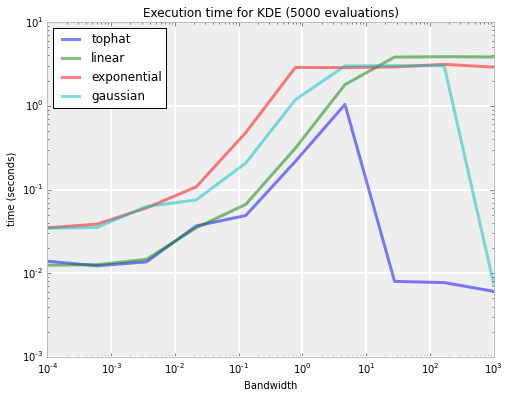

In [13]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=np.logspace(-4, 3, 10),
                       N=1E4, rtol=1E-4);

Notice the two regions of interest: for very small bandwidths, kernels with a hard cutoff
(tophat, linear) out-perform kernels with a broad taper (gaussian, exponential).  And tapered
kernels which fall off more quickly (gaussian, with $p \sim \exp(-d^2)$) are more efficiently
computed than kernels which fall off more slowly (exponential, with $p \sim \exp(-d)$).

At the other end, kernels with very flat profiles near zero (tophat, gaussian) show improvement
for large bandwidths, while kernels with very steep profiles near zero (linear, exponential)
show no improvement: they reach the asymptotic limit in which all of the $\mathcal{O}[MN]$
distances must be computed.

For good measure, here are the scalings of the computations with ``rtol`` and with *N*:

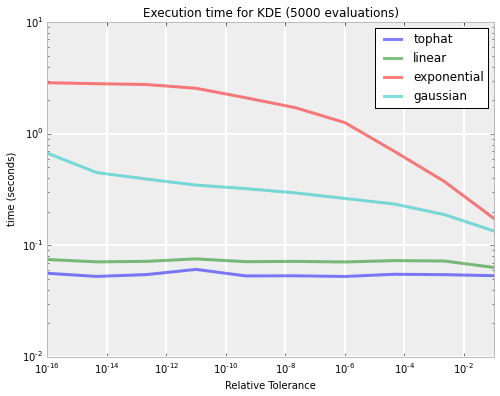

In [14]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=0.15, N=1E4, rtol=np.logspace(-16, -1, 10));

As we'd expect, for a reasonable kernel size, ``rtol`` is not significant for kernels with a
hard cutoff, and becomes more significant the wider the "wings" of the kernel are.
The scaling with *N* is also as we'd expect:

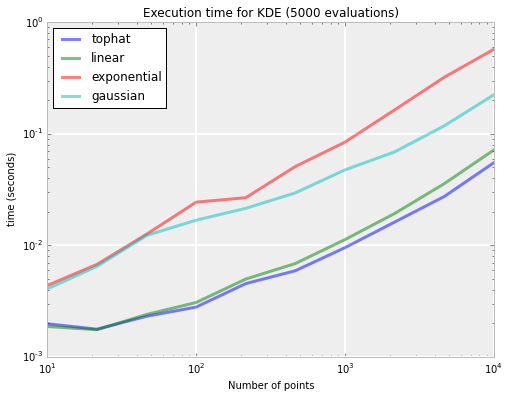

In [15]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=0.15, rtol=1E-4, N=np.logspace(1, 4, 10));

This dependence of computation time on bandwidth and kernel shape is an issue
to keep in mind as you choose your KDE algorithm: in the case of tree-based approaches,
the bandwidth and kernel can matter to the tune of several orders of magnitude in computation time!

## Conclusion
I hope all this has been helpful to you: my main takeaway is that under most situations that are applicable to my own research, the Scikit-learn KDE is far superior to the other implementations that are available.  There are situations where other choices are appropriate (namely, Statsmodels' ``KDEMultivariate`` when your data is heterogeneous, or Scipy's ``gaussian_kde`` for exact results with fewer than about 500 points), but scikit-learn will be much faster for most other relevant settings.

Finally, here are some of the functions I used to generate the above plots.  If you download this notebook, you'll have to execute this cell before running any of the above cells that use these:

In [20]:
X_src = np.zeros(1)
X_src

array([0.])

In [43]:
import matplotlib
from collections import defaultdict
from time import time

functions = dict(zip(kde_funcnames, kde_funcs))


def plot_scaling(N=1000, bandwidth=0.1, rtol=0.0,
                 Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling of KDE algorithms.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    for name in functions:
        if name not in kwds:
            kwds[name] = {}
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        kwds['Scikit-learn']['rtol'] = rtol_i
        for name, func in functions.items():
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                func(x, xgrid, bw_i, **kwds[name])
                t1 = time()
                t += (t1 - t0)
            times[name].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for name in kde_funcnames:
            ax.loglog(N, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for name in kde_funcnames:
            ax.loglog(bandwidth, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for name in kde_funcnames:
            ax.loglog(rtol, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_scaling_vs_kernel(kernels, N=1000, bandwidth=0.1, rtol=0.0,
                           Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling for Scikit-learn kernels.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        for kernel in kernels:
            kwds['kernel'] = kernel
            kwds['rtol'] = rtol_i
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                kde_sklearn(x, xgrid, bw_i, **kwds)
                t1 = time()
                t += (t1 - t0)
            times[kernel].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for kernel in kernels:
            ax.loglog(N, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for kernel in kernels:
            ax.loglog(bandwidth, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for kernel in kernels:
            ax.loglog(rtol, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()

I hope you found this post useful - Happy coding!

*This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.com/downloads/notebooks/KDEBench.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.com/downloads/notebooks/KDEBench.ipynb).*